In [1]:
import numpy as np
import matplotlib.pyplot as plt



from functions.parse_data import synth_dataloader
import functions.handy_functions as hf
import torch

from cot_train.utils import MLP5

from pysolar.solar import *

2024-04-16 08:26:02.651552: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 08:26:02.689305: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-16 08:26:02.689334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-16 08:26:02.690232: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-16 08:26:02.697100: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#Load in images with information
import xarray as xr
f='/cloud/openeo/tiny_forest_5'
loaded_data = xr.open_dataset(f, engine='netcdf4', decode_times=True)
nodata = loaded_data.attrs.get("nodata", None)
loaded_data = loaded_data.where(loaded_data != nodata, np.nan)
times=loaded_data['t']
variables=loaded_data.variables
loaded_data

<xarray.Dataset> Size: 20MB
Dimensions:      (t: 7, y: 170, x: 178, sun_zenith: 7)
Coordinates:
  * t            (t) datetime64[ns] 56B 2020-06-13T10:30:31.024000 ... 2020-0...
  * y            (y) float64 1kB 6.51e+06 6.51e+06 ... 6.508e+06 6.508e+06
  * x            (x) float64 1kB 4.782e+05 4.782e+05 ... 4.8e+05 4.8e+05
    spatial_ref  int32 4B 3006
  * sun_zenith   (sun_zenith) float64 56B 35.3 31.92 34.05 ... 34.83 31.44 33.54
Data variables: (12/16)
    b02          (t, y, x) float64 2MB 795.0 791.0 802.0 ... 1.223e+03 1.218e+03
    b03          (t, y, x) float64 2MB 606.0 612.0 636.0 ... 1.036e+03 1.058e+03
    b04          (t, y, x) float64 2MB 376.0 365.0 377.0 ... 791.0 798.0 849.0
    b05          (t, y, x) float64 2MB 619.0 588.0 588.0 ... 1.007e+03 1.028e+03
    b06          (t, y, x) float64 2MB 1.336e+03 1.304e+03 ... 1.843e+03
    b07          (t, y, x) float64 2MB 1.525e+03 1.548e+03 ... 2.169e+03
    ...           ...
    b11          (t, y, x) float64 2MB 728.0 700.0 700.0 ... 1.183e+03 1.184e+03
    b12          (t, y, x) float64 2MB 323.0 319.0 319.0 ... 646.0 646.0 653.0
    west         float64 8B 14.62
    east         float64 8B 14.65
    north        float64 8B 58.73
    south        float64 8B 58.71
Attributes:
    crs:                EPSG:3006
    nodata:             -9999
    collection:         s2_msi_l1c
    datetime_from_dim:  2024-03-27T12:10:53.308569

In [3]:
## Setup for calculating RGB images

maxR = 3.0 ## max reflectance
midR = 0.13
sat = 1.3
gamma = 2.3
ray = { 'r': 0.013, 'g': 0.024, 'b': 0.041}



gOff = 0.01
gOffPow = gOff**gamma
gOffRange = (1 + gOff)**gamma - gOffPow


adjGamma = lambda b : ((b + gOff)**gamma - gOffPow)/gOffRange


def adj(a,tx,ty,maxC):
    ar = a/maxC
    ar[ar>1]=1
    ar[ar<0]=0
    return ar*(ar*(tx/maxC + ty - 1)- ty)/(ar*(2*tx/maxC - 1) - tx / maxC)

def satEnh(r,g,b):
    avgS = (r + g + b) / 3.0 * (1 - sat)
    tmpr=avgS + r * sat
    tmpr[tmpr>1]=1
    tmpr[tmpr<0]=0
    tmpg=avgS + g * sat
    tmpg[tmpg>1]=1
    tmpg[tmpg<0]=0
    tmpb=avgS + b * sat
    tmpb[tmpb>1]=1
    tmpb[tmpb<0]=0
    return [tmpr, tmpg, tmpb]


sAdj = lambda a: adjGamma(adj(a, midR, 1, maxR))
sRGB = lambda c: (12.92 * c) if c<= 0.0031308 else (1.055 * c**0.41666666666 - 0.055)

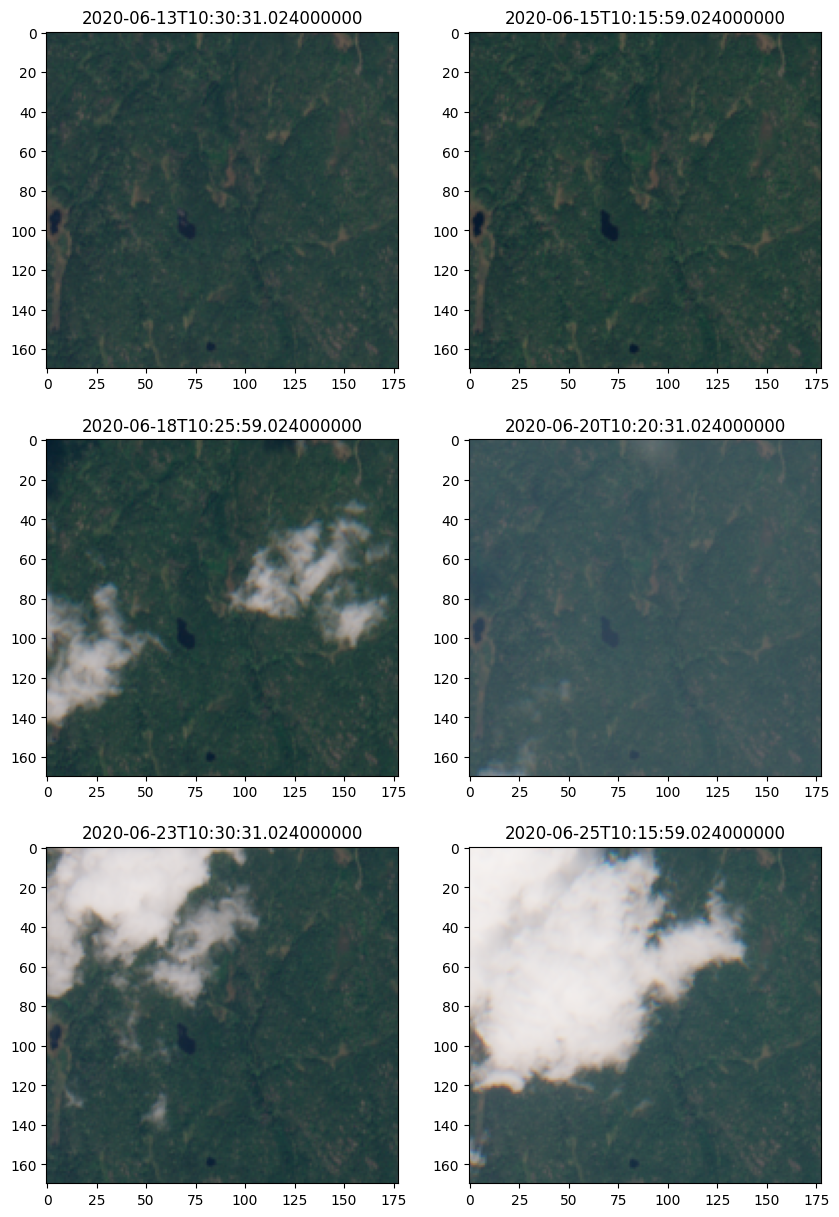

In [4]:
ncols=2
nrows=int(np.ceil((len(times)-1)/ncols))
divide=10000
ims=[]
ims_show=[]
sun_zenith_angles=loaded_data.sun_zenith.data

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig, axs = plt.subplots(ncols=ncols,nrows=nrows)
for i,ax in enumerate(axs.ravel()):

    ## Get bands ##
    b02=variables['b02'].data[i,:,:]/divide
    b03=variables['b03'].data[i,:,:]/divide
    b04=variables['b04'].data[i,:,:]/divide
    b05=variables['b05'].data[i,:,:]/divide
    b06=variables['b06'].data[i,:,:]/divide
    b07=variables['b07'].data[i,:,:]/divide
    b08=variables['b08'].data[i,:,:]/divide
    b8a=variables['b8a'].data[i,:,:]/divide
    b09=variables['b09'].data[i,:,:]/divide
    b10=variables['b10'].data[i,:,:]/divide
    b11=variables['b11'].data[i,:,:]/divide
    b12=variables['b12'].data[i,:,:]/divide

    ## Get "True" RGB ##
    b04T=sAdj(b04-ray['r'])
    b03T=sAdj(b03-ray['g'])
    b02T=sAdj(b02-ray['b'])

    rgbLin=satEnh(b04T,b03T,b02T)
    #avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
    for k,p in enumerate(rgbLin[0]):
        for j,q in enumerate(p):
            rgbLin[0][k,j]=sRGB(q)
    for k,p in enumerate(rgbLin[1]):
        for j,q in enumerate(p):
            rgbLin[1][k,j]=sRGB(q)
    for k,p in enumerate(rgbLin[2]):
        for j,q in enumerate(p):
            rgbLin[2][k,j]=sRGB(q)

    im_show=np.zeros((np.shape(b03)[0],np.shape(b03)[1],3))
    im_show[:,:,0]=rgbLin[0]
    im_show[:,:,1]=rgbLin[1]
    im_show[:,:,2]=rgbLin[2]
    ims_show.append(im_show)

    ## Save image ##
    im=np.zeros((np.shape(b03)[0],np.shape(b03)[1],12))
    im[:,:,0]=b02
    im[:,:,1]=b03
    im[:,:,2]=b04
    im[:,:,3]=b05
    im[:,:,4]=b06
    im[:,:,5]=b07
    im[:,:,6]=b08
    im[:,:,7]=b8a
    im[:,:,8]=b09
    im[:,:,9]=b10
    im[:,:,10]=b11
    im[:,:,11]=b12
    ims.append(im)

    ax.imshow(im_show)
    ax.set_title(times.data[i])
    

In [5]:
#pair=[5,6] # For tiny_forest_2
#pair=[1,0] # tiny_forest_3
pair=[1,2] # tiny_forest_4
im_clear=ims[pair[0]]
im_cloud=ims[pair[1]]

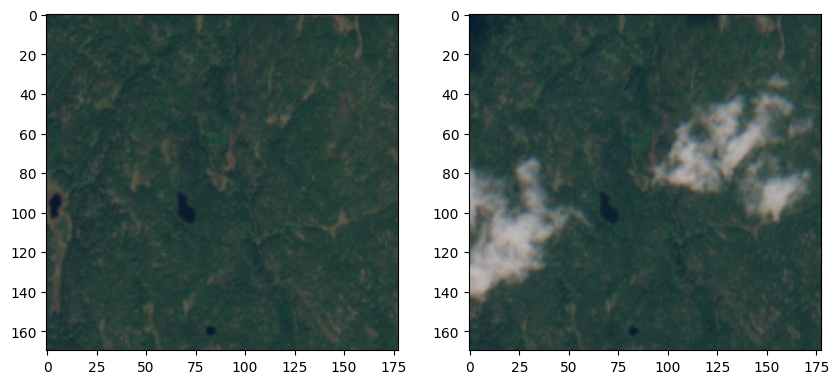

In [6]:
plt.rcParams['figure.figsize'] = [10, 5]
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0].imshow(ims_show[pair[0]])
axs[1].imshow(ims_show[pair[1]])

In [7]:
## Load models
main_filepath='pytorch_models/Angles_as_input-Sun_Zen'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))

In [11]:
## Reshape cloudy data
im_shape=np.shape(im_cloud)
im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2]+1)) #+1 for sun zenith angle
for i in range(im_shape[2]):
    im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

im_cloud_r[:,-1]=sun_zenith_angles[pair[1]]


In [9]:

## Make prediction
for i,model in enumerate(models):
    if i==0:
        pred=model.predict(im_cloud_r)
    else:   
        pred=pred+model.predict(im_cloud_r)
pred=pred/len(models)

In [10]:
##Reshape back
index_median=1
im_pred=np.zeros(im_shape)
im_unc=np.zeros(im_shape)
for i in range(im_shape[2]):
    im_pred[:,:,i]=np.reshape(pred[:,i,index_median],im_shape[0:2])
    im_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],im_shape[0:2])

In [11]:
print(np.shape(im_pred))
print(np.shape(im_unc))

(170, 178, 12)
(170, 178, 12)


In [12]:
## Get "True" RGB ##
b04Tp=sAdj(im_pred[:,:,2]-ray['r'])
b03Tp=sAdj(im_pred[:,:,1]-ray['g'])
b02Tp=sAdj(im_pred[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_pred_show=np.zeros((np.shape(b03)[0],np.shape(b03)[1],3))
im_pred_show[:,:,0]=rgbLin[0]
im_pred_show[:,:,1]=rgbLin[1]
im_pred_show[:,:,2]=rgbLin[2]

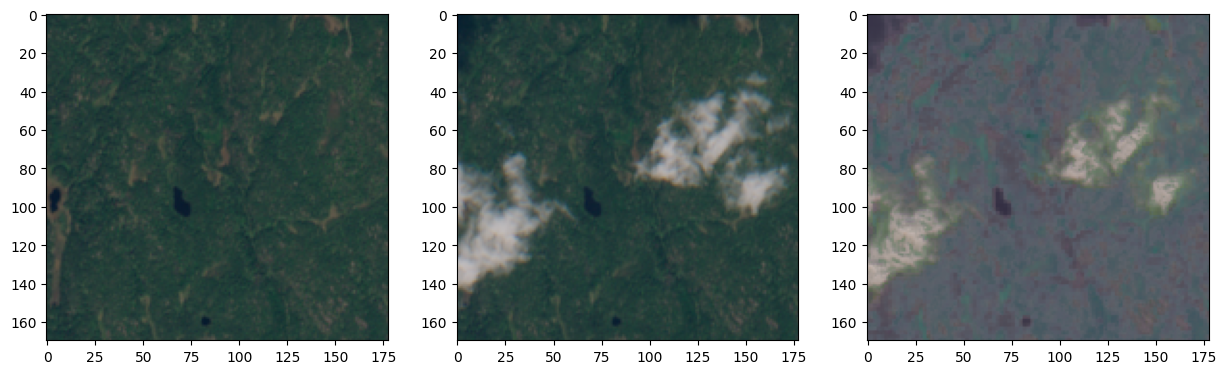

In [13]:
plt.rcParams['figure.figsize'] = [15, 5]
fig,axs=plt.subplots(ncols=3,nrows=1)
axs[0].imshow(ims_show[pair[0]])
axs[1].imshow(ims_show[pair[1]])
axs[2].imshow(im_pred_show)

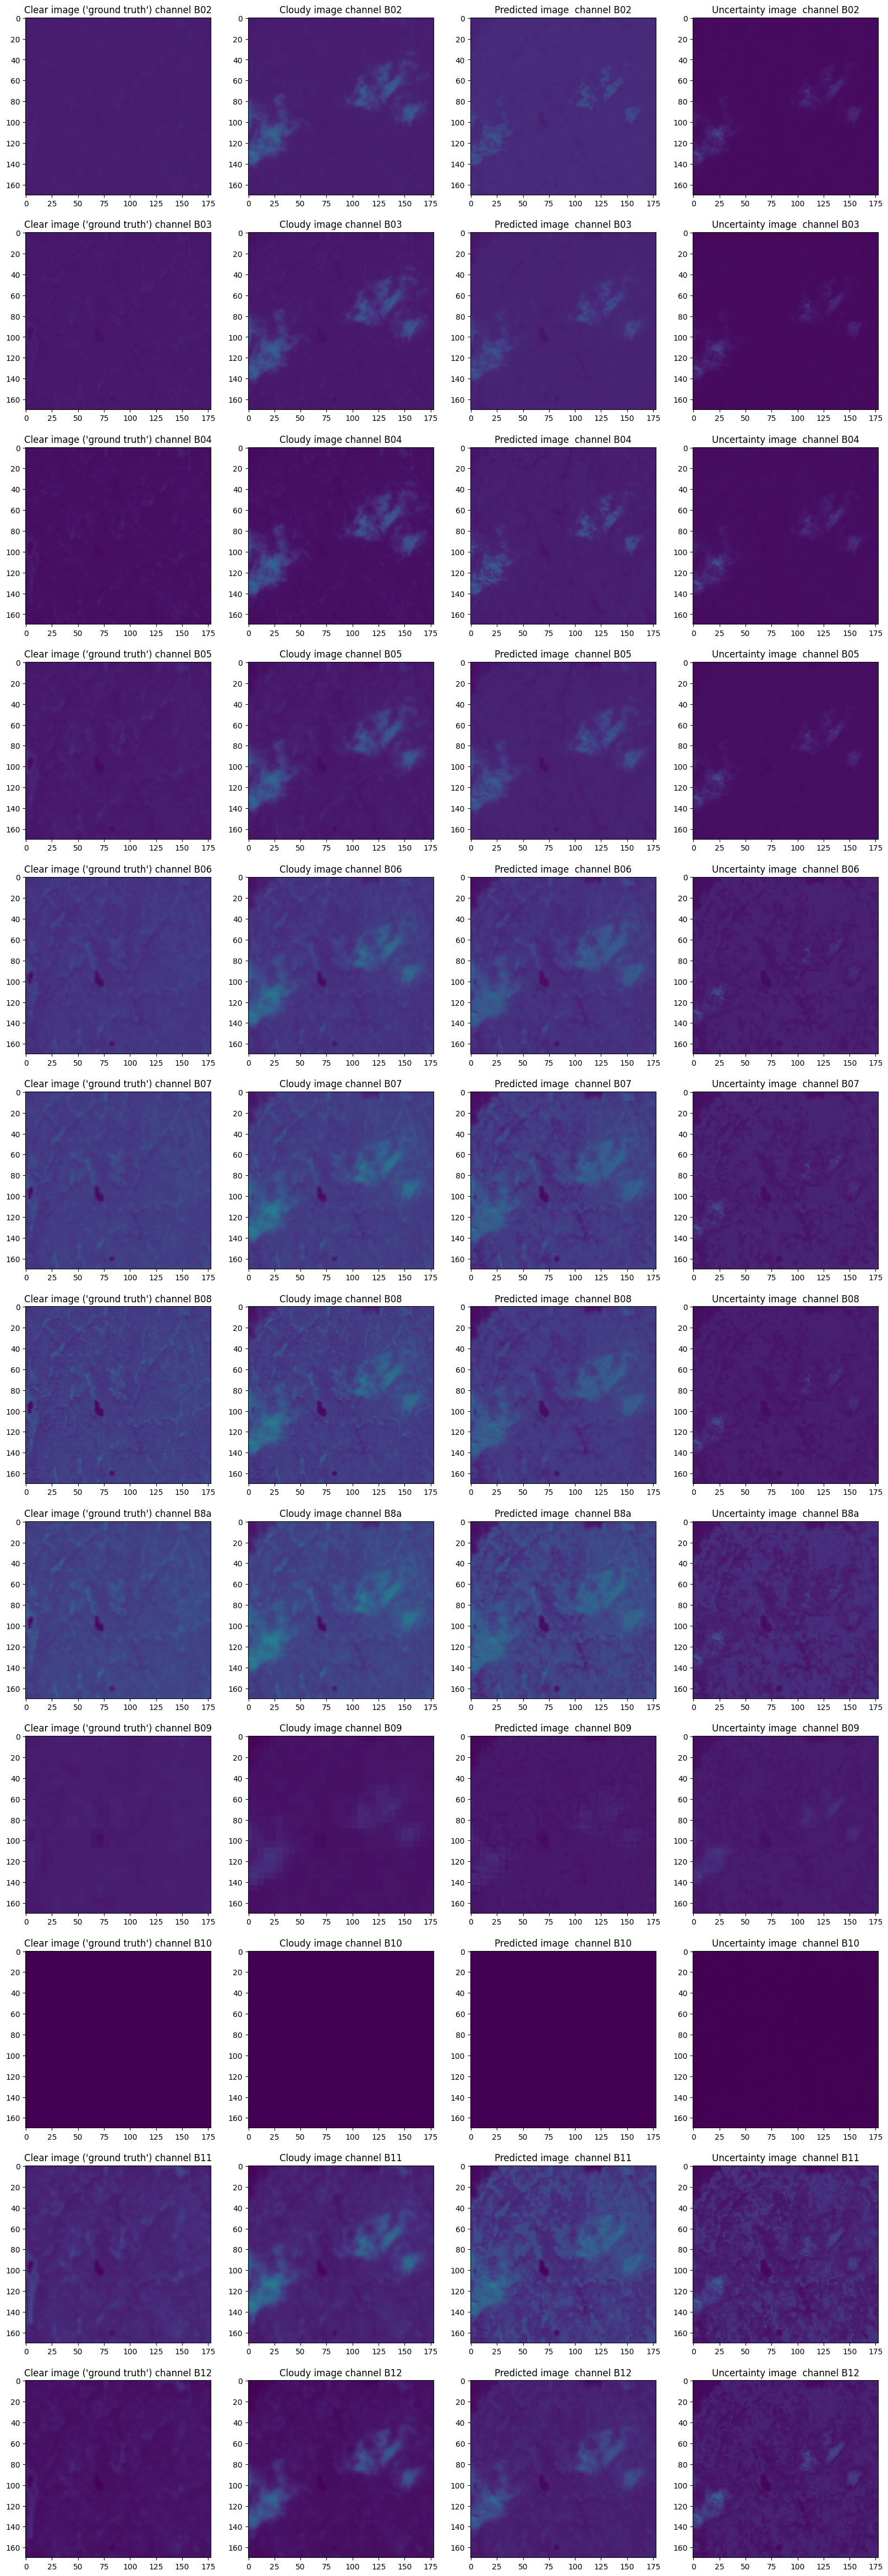

In [14]:
nchannels=12
plt.rcParams['figure.figsize'] = [20, 5*nchannels]
fig,axs=plt.subplots(ncols=4,nrows=nchannels)
for i in range(nchannels):
    axs[i,0].imshow(im_clear[:,:,i],vmin=0,vmax=1)
    axs[i,1].imshow(im_cloud[:,:,i],vmin=0,vmax=1)
    im_tmp=axs[i,2].imshow(im_pred[:,:,i],vmin=0,vmax=1)
    
    axs[i,3].imshow(im_unc[:,:,i],vmin=0,vmax=1)
    

    if i<7:
        axs[i,0].set_title("Clear image ('ground truth') channel B0"+str(i+2))
        axs[i,1].set_title("Cloudy image channel B0"+str(i+2))
        axs[i,2].set_title("Predicted image  channel B0"+str(i+2))
        axs[i,3].set_title("Uncertainty image  channel B0"+str(i+2))
    elif i==7:
        axs[i,0].set_title("Clear image ('ground truth') channel B8a")
        axs[i,1].set_title("Cloudy image channel B8a")
        axs[i,2].set_title("Predicted image  channel B8a")
        axs[i,3].set_title("Uncertainty image  channel B8a")
    elif i==8:
        axs[i,0].set_title("Clear image ('ground truth') channel B0"+str(i+1))
        axs[i,1].set_title("Cloudy image channel B0"+str(i+1))
        axs[i,2].set_title("Predicted image  channel B0"+str(i+1))
        axs[i,3].set_title("Uncertainty image  channel B0"+str(i+1))
    else:
        axs[i,0].set_title("Clear image ('ground truth') channel B"+str(i+1))
        axs[i,1].set_title("Cloudy image channel B"+str(i+1))
        axs[i,2].set_title("Predicted image  channel B"+str(i+1))
        axs[i,3].set_title("Uncertainty image  channel B"+str(i+1))

In [15]:
#np.linal.norm() -> Frobenius norm i.e root of the sum of squares
norm_og=np.linalg.norm(np.square((im_clear)-(im_cloud)),axis=(0,1))**2
norm_pred=np.linalg.norm(np.square((im_clear)-im_pred),axis=(0,1))**2
norm_gt=np.linalg.norm(np.square(im_clear),axis=(0,1))**2

NMSE_og=norm_og/norm_gt
NMSE_pred=norm_pred/norm_gt

for i in range(len(NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(NMSE_pred[i]))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(NMSE_pred[i]))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(NMSE_pred[i]))    

    print(' ')

NMSE before correction, Band 2: 1.0138240622272392
NMSE after correction, Band 2: 0.33836347278904777
 
NMSE before correction, Band 3: 1.9203154913745937
NMSE after correction, Band 3: 0.7330941500206426
 
NMSE before correction, Band 4: 15.179071437111068
NMSE after correction, Band 4: 8.24534012274535
 
NMSE before correction, Band 5: 1.8003494565258744
NMSE after correction, Band 5: 1.0078654854782845
 
NMSE before correction, Band 6: 0.06905843466868061
NMSE after correction, Band 6: 0.030487405660635934
 
NMSE before correction, Band 7: 0.041539275948653746
NMSE after correction, Band 7: 0.017655486659565147
 
NMSE before correction, Band 8: 0.03249465771967791
NMSE after correction, Band 8: 0.014022257632314138
 
NMSE before correction, Band 8A: 0.028626602621410195
NMSE after correction, Band 8A: 0.014131327268104553
 
NMSE before correction, Band 9: 0.020094394686398943
NMSE after correction, Band 9: 0.0058369319729700804
 
NMSE before correction, Band 10: 0.009193989323459727

## COT model

In [12]:
from cot_train.utils import StatCollector, MLP5, mlp_inference
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
#model_load_paths=['smhi_models3/0/model_it_2000000','smhi_models3/1/model_it_2000000', 'smhi_models3/2/model_it_2000000','smhi_models3/3/model_it_2000000', 'smhi_models3/4/model_it_2000000',
#                 'smhi_models3/5/model_it_2000000','smhi_models3/6/model_it_2000000', 'smhi_models3/7/model_it_2000000','smhi_models3/8/model_it_2000000', 'smhi_models3/9/model_it_2000000']
model_load_paths=['smhi_models4/0/model_it_2000000','smhi_models4/1/model_it_2000000', 'smhi_models4/2/model_it_2000000','smhi_models4/3/model_it_2000000', 'smhi_models4/4/model_it_2000000']

input_dim = 13
output_dim = 1

models_cot=[]
for model_path in model_load_paths:
    model_cot = MLP5(input_dim, output_dim, apply_relu=True)
    model_cot.load_state_dict(torch.load(model_path, map_location=device))
    model_cot.to(device)
    models_cot.append(model_cot)

In [18]:
#means=[0.534958,0.538317,0.532992,0.629737,0.826885,0.859306,0.803385,0.880321,0.408178,0.066565,0.428241,0.301306,58.076266]
#stds=[0.218962,0.188747,0.236514,0.185751,0.169492,0.170012,0.162448,0.171793,0.237684,0.096908,0.309903,0.202586,15.602082]

means=[0.5159022, 0.48930507, 0.57624751, 0.54434123, 0.66352627, 0.93152929, 0.89793559, 0.98973655, 0.4456635,  0.07007362, 0.50300405, 0.40412671, 58.0061154]
stds =[0.27741833, 0.27350627, 0.28171366, 0.30964284, 0.27881009, 0.31931352, 0.32986593, 0.36227525, 0.28535278, 0.10695668, 0.41583674, 0.32312217, 15.556165358432096]

In [19]:
inputs = (im_cloud_r - means) / stds

image_input_tens=torch.Tensor(inputs).to(device)
#image_pred_cot=model_cot(image_input_tens).cpu().data.numpy()*50

preds = 0
for model_cot in models_cot:
    curr_preds=model_cot(image_input_tens)/len(models_cot)
    preds=preds+curr_preds

image_pred_cot=50*preds.cpu().data.numpy() #unnormalise

## Reshape back
im_pred_cot=np.reshape(image_pred_cot,im_shape[0:2])

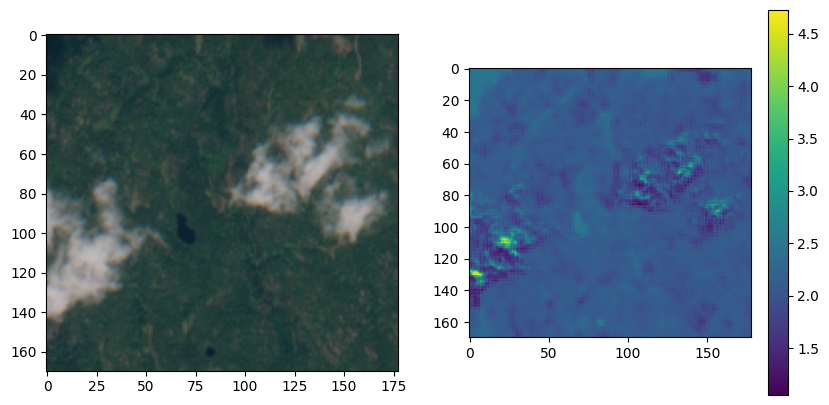

In [20]:
plt.rcParams['figure.figsize'] = [10, 5]
fig,axs =plt.subplots(ncols=2,nrows=1)
axs[0].imshow(ims_show[pair[1]])
im_cot=axs[1].imshow(im_pred_cot)
fig.colorbar(im_cot,ax=axs[1])

In [42]:
#Sort into categories instead
#t_is_cloud = 0.025*50 #From Pirinen et. al.
#t_thin_cloud = 0.015*50 #From Pirinen et. al.

t_is_cloud = 0.025*50 #From Pirinen et. al.
t_thin_cloud = 0.019*50 #From Pirinen et. al.

pred_clear = np.zeros(image_pred_cot.shape)
pred_thin = np.zeros(image_pred_cot.shape)
pred_thick = np.zeros(image_pred_cot.shape)

pred_clear[image_pred_cot<t_thin_cloud]=1
pred_thin[(image_pred_cot>=t_thin_cloud)&(image_pred_cot<t_is_cloud)]=1
pred_thick[image_pred_cot>=t_is_cloud]=1

#Append to cloudy data
im_cloud_r=np.concatenate((im_cloud_r,pred_clear,pred_thin,pred_thick),axis=1)

## Reshape back
im_pred_clear=np.reshape(pred_clear,im_shape[0:2])
im_pred_thin=np.reshape(pred_thin,im_shape[0:2])
im_pred_thick=np.reshape(pred_thick,im_shape[0:2])



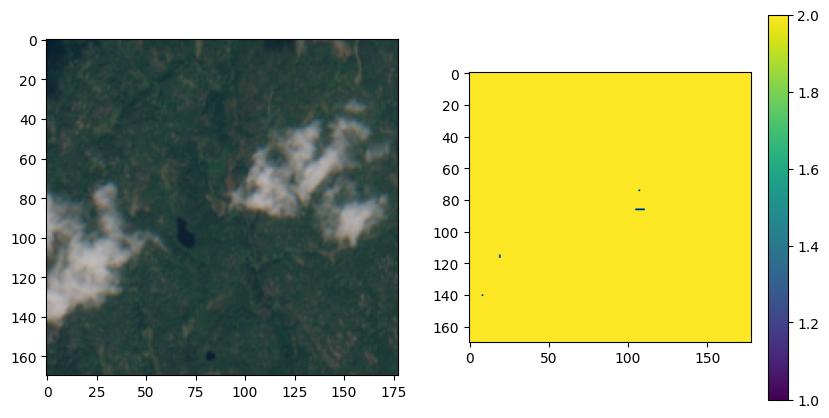

In [43]:
im_pred_cat = im_pred_thin+2*im_pred_thick

plt.rcParams['figure.figsize'] = [10, 5]
fig,axs =plt.subplots(ncols=2,nrows=1)
axs[0].imshow(ims_show[pair[1]])
im_cot=axs[1].imshow(im_pred_cat)
fig.colorbar(im_cot,ax=axs[1])

In [23]:
## Load models
main_filepath='pytorch_models/Final_model'
n_ensemble=10
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))

## Make prediction
for i,model in enumerate(models):
    if i==0:
        pred=model.predict(im_cloud_r)
    else:   
        pred=pred+model.predict(im_cloud_r)
pred=pred/len(models)

##Reshape back
index_median=1
im_pred=np.zeros(im_shape)
im_unc=np.zeros(im_shape)
for i in range(im_shape[2]):
    im_pred[:,:,i]=np.reshape(pred[:,i,index_median],im_shape[0:2])
    im_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],im_shape[0:2])

In [24]:
## Get "True" RGB ##
b04Tp=sAdj(im_pred[:,:,2]-ray['r'])
b03Tp=sAdj(im_pred[:,:,1]-ray['g'])
b02Tp=sAdj(im_pred[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_pred_show=np.zeros((np.shape(b03)[0],np.shape(b03)[1],3))
im_pred_show[:,:,0]=rgbLin[0]
im_pred_show[:,:,1]=rgbLin[1]
im_pred_show[:,:,2]=rgbLin[2]

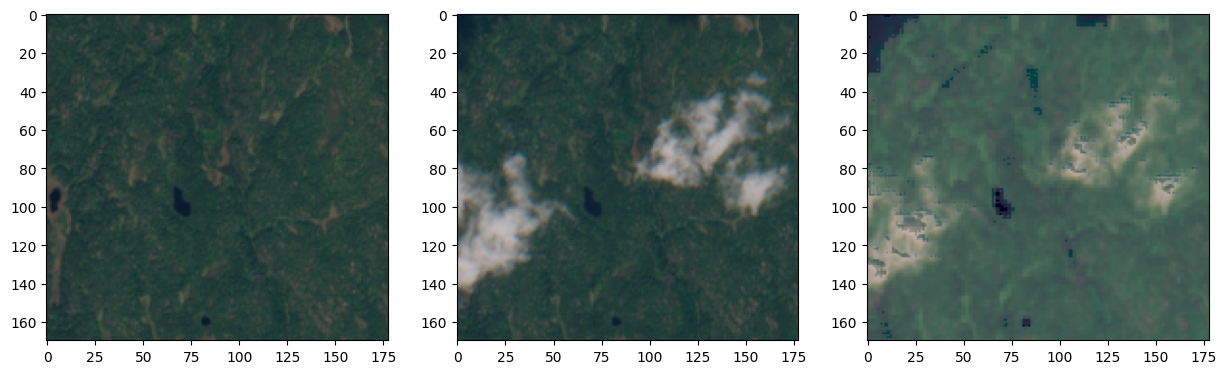

In [25]:
plt.rcParams['figure.figsize'] = [15, 5]
fig,axs=plt.subplots(ncols=3,nrows=1)
axs[0].imshow(ims_show[pair[0]])
axs[1].imshow(ims_show[pair[1]])
axs[2].imshow(im_pred_show)

In [26]:
#np.linal.norm() -> Frobenius norm i.e root of the sum of squares
norm_og=np.linalg.norm(np.square((im_clear)-(im_cloud)),axis=(0,1))**2
norm_pred=np.linalg.norm(np.square((im_clear)-im_pred),axis=(0,1))**2
norm_gt=np.linalg.norm(np.square(im_clear),axis=(0,1))**2

NMSE_og=norm_og/norm_gt
NMSE_pred=norm_pred/norm_gt

for i in range(len(NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(NMSE_pred[i]))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(NMSE_pred[i]))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(NMSE_pred[i]))    

    print(' ')


print('Mean NMSE before correction: '+str(np.mean(NMSE_og)))
print('Mean NMSE after correction: '+str(np.mean(NMSE_pred)))

NMSE before correction, Band 2: 1.0138240622272392
NMSE after correction, Band 2: 0.20886061895303193
 
NMSE before correction, Band 3: 1.9203154913745937
NMSE after correction, Band 3: 0.768929179811669
 
NMSE before correction, Band 4: 15.179071437111068
NMSE after correction, Band 4: 7.052153133521156
 
NMSE before correction, Band 5: 1.8003494565258744
NMSE after correction, Band 5: 1.2938800515800468
 
NMSE before correction, Band 6: 0.06905843466868061
NMSE after correction, Band 6: 0.053034291675692506
 
NMSE before correction, Band 7: 0.041539275948653746
NMSE after correction, Band 7: 0.029623869019658015
 
NMSE before correction, Band 8: 0.03249465771967791
NMSE after correction, Band 8: 0.020297475602604545
 
NMSE before correction, Band 8A: 0.028626602621410195
NMSE after correction, Band 8A: 0.017947312655255825
 
NMSE before correction, Band 9: 0.020094394686398943
NMSE after correction, Band 9: 0.026575932002703705
 
NMSE before correction, Band 10: 0.009193989323459727


In [27]:
## Load models
main_filepath='pytorch_models/Final_model_no_clear_noise'
n_ensemble=10
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))

## Make prediction
for i,model in enumerate(models):
    if i==0:
        pred=model.predict(im_cloud_r)
    else:   
        pred=pred+model.predict(im_cloud_r)
pred=pred/len(models)

##Reshape back
index_median=1
im_pred=np.zeros(im_shape)
im_unc=np.zeros(im_shape)
for i in range(im_shape[2]):
    im_pred[:,:,i]=np.reshape(pred[:,i,index_median],im_shape[0:2])
    im_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],im_shape[0:2])

In [28]:
## Get "True" RGB ##
def TrueRGB(im_in):
    ray = { 'r': 0.013, 'g': 0.024, 'b': 0.041}
    b04Tp=sAdj(im_in[:,:,2]-ray['r'])
    b03Tp=sAdj(im_in[:,:,1]-ray['g'])
    b02Tp=sAdj(im_in[:,:,0]-ray['b'])

    rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
    #avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
    for k,p in enumerate(rgbLin[0]):
        for j,q in enumerate(p):
            rgbLin[0][k,j]=sRGB(q)
    for k,p in enumerate(rgbLin[1]):
        for j,q in enumerate(p):
            rgbLin[1][k,j]=sRGB(q)
    for k,p in enumerate(rgbLin[2]):
        for j,q in enumerate(p):
            rgbLin[2][k,j]=sRGB(q)

    im_show=np.zeros((np.shape(b03)[0],np.shape(b03)[1],3))
    im_show[:,:,0]=rgbLin[0]
    im_show[:,:,1]=rgbLin[1]
    im_show[:,:,2]=rgbLin[2]

    return im_show

In [29]:
im_pred_show=TrueRGB(im_pred)

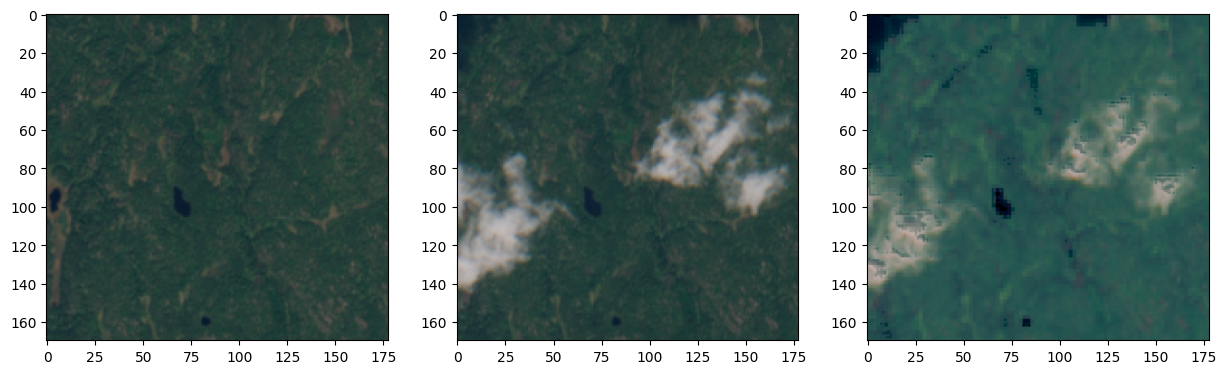

In [30]:
plt.rcParams['figure.figsize'] = [15, 5]
fig,axs=plt.subplots(ncols=3,nrows=1)
axs[0].imshow(ims_show[pair[0]])
axs[1].imshow(ims_show[pair[1]])
axs[2].imshow(im_pred_show)

In [31]:
#np.linal.norm() -> Frobenius norm i.e root of the sum of squares
norm_og=np.linalg.norm(np.square((im_clear)-(im_cloud)),axis=(0,1))**2
norm_pred=np.linalg.norm(np.square((im_clear)-im_pred),axis=(0,1))**2
norm_gt=np.linalg.norm(np.square(im_clear),axis=(0,1))**2

NMSE_og=norm_og/norm_gt
NMSE_pred=norm_pred/norm_gt

for i in range(len(NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(NMSE_pred[i]))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(NMSE_pred[i]))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(NMSE_pred[i]))    

    print(' ')

print('Mean NMSE before correction: '+str(np.mean(NMSE_og)))
print('Mean NMSE after correction: '+str(np.mean(NMSE_pred)))

NMSE before correction, Band 2: 1.0138240622272392
NMSE after correction, Band 2: 0.16152567708961527
 
NMSE before correction, Band 3: 1.9203154913745937
NMSE after correction, Band 3: 0.4806716048234015
 
NMSE before correction, Band 4: 15.179071437111068
NMSE after correction, Band 4: 4.293081169705538
 
NMSE before correction, Band 5: 1.8003494565258744
NMSE after correction, Band 5: 0.807908739315863
 
NMSE before correction, Band 6: 0.06905843466868061
NMSE after correction, Band 6: 0.04938150582921893
 
NMSE before correction, Band 7: 0.041539275948653746
NMSE after correction, Band 7: 0.03044547484548095
 
NMSE before correction, Band 8: 0.03249465771967791
NMSE after correction, Band 8: 0.021562337906517723
 
NMSE before correction, Band 8A: 0.028626602621410195
NMSE after correction, Band 8A: 0.021224314170083258
 
NMSE before correction, Band 9: 0.020094394686398943
NMSE after correction, Band 9: 0.040079957206924734
 
NMSE before correction, Band 10: 0.009193989323459727
NM

In [32]:
uncmeans = np.mean(im_unc,axis=2)

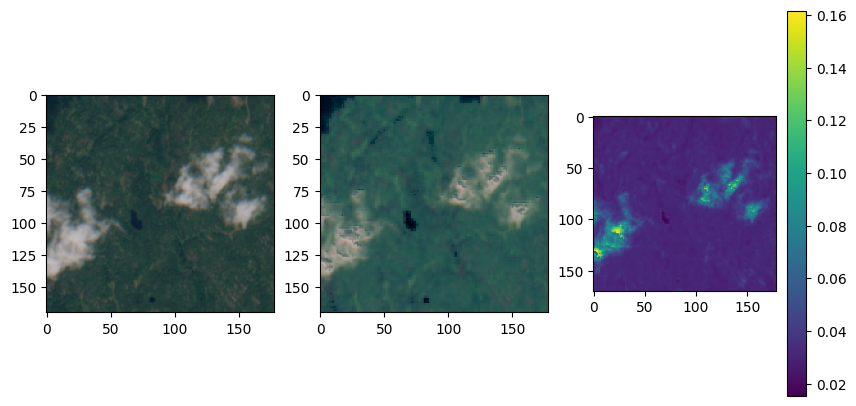

In [33]:
plt.rcParams['figure.figsize'] = [10, 5]
fig,axs =plt.subplots(ncols=3,nrows=1)
axs[0].imshow(ims_show[pair[1]])
axs[1].imshow(im_pred_show)
unc_img=axs[2].imshow(uncmeans)
fig.colorbar(unc_img,ax=axs[2])

In [34]:
## Load models
main_filepath='pytorch_models/Final_model_no_clear_noise_newsurf'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))

## Make prediction
for i,model in enumerate(models):
    if i==0:
        pred=model.predict(im_cloud_r)
    else:   
        pred=pred+model.predict(im_cloud_r)
pred=pred/len(models)

##Reshape back
index_median=1
im_pred=np.zeros(im_shape)
im_unc=np.zeros(im_shape)
for i in range(im_shape[2]):
    im_pred[:,:,i]=np.reshape(pred[:,i,index_median],im_shape[0:2])
    im_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],im_shape[0:2])

In [35]:
im_pred_show=TrueRGB(im_pred)

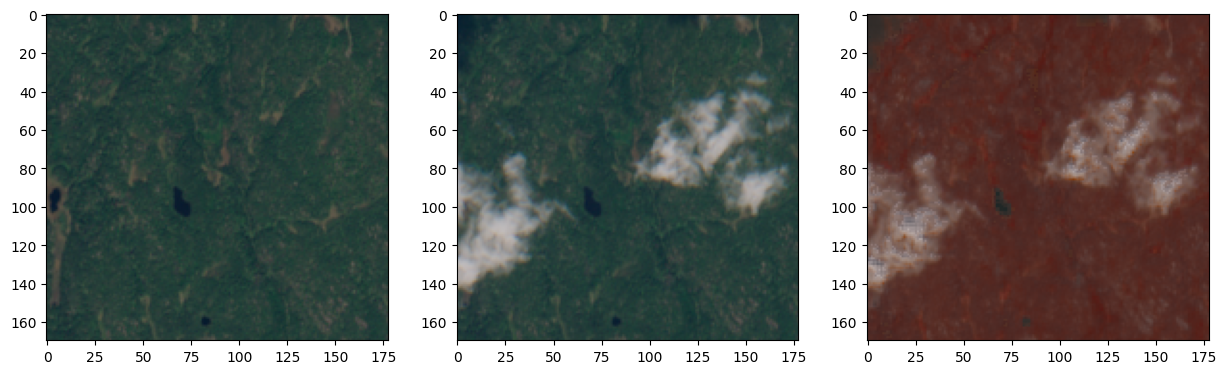

In [36]:
plt.rcParams['figure.figsize'] = [15, 5]
fig,axs=plt.subplots(ncols=3,nrows=1)
axs[0].imshow(ims_show[pair[0]])
axs[1].imshow(ims_show[pair[1]])
axs[2].imshow(im_pred_show)

In [37]:
#np.linal.norm() -> Frobenius norm i.e root of the sum of squares
norm_og=np.linalg.norm(np.square((im_clear)-(im_cloud)),axis=(0,1))**2
norm_pred=np.linalg.norm(np.square((im_clear)-im_pred),axis=(0,1))**2
norm_gt=np.linalg.norm(np.square(im_clear),axis=(0,1))**2

NMSE_og=norm_og/norm_gt
NMSE_pred=norm_pred/norm_gt

for i in range(len(NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(NMSE_pred[i]))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(NMSE_pred[i]))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(NMSE_pred[i]))    

    print(' ')

print('Mean NMSE before correction: '+str(np.mean(NMSE_og)))
print('Mean NMSE before correction: '+str(np.mean(NMSE_pred)))

NMSE before correction, Band 2: 1.0138240622272392
NMSE after correction, Band 2: 0.06350057554981953
 
NMSE before correction, Band 3: 1.9203154913745937
NMSE after correction, Band 3: 0.13716642163213325
 
NMSE before correction, Band 4: 15.179071437111068
NMSE after correction, Band 4: 3.655198261955467
 
NMSE before correction, Band 5: 1.8003494565258744
NMSE after correction, Band 5: 0.5446173903419448
 
NMSE before correction, Band 6: 0.06905843466868061
NMSE after correction, Band 6: 0.020208920694522715
 
NMSE before correction, Band 7: 0.041539275948653746
NMSE after correction, Band 7: 0.014785091254353082
 
NMSE before correction, Band 8: 0.03249465771967791
NMSE after correction, Band 8: 0.012948840876313143
 
NMSE before correction, Band 8A: 0.028626602621410195
NMSE after correction, Band 8A: 0.010792056818590658
 
NMSE before correction, Band 9: 0.020094394686398943
NMSE after correction, Band 9: 0.012264081120427588
 
NMSE before correction, Band 10: 0.00919398932345972

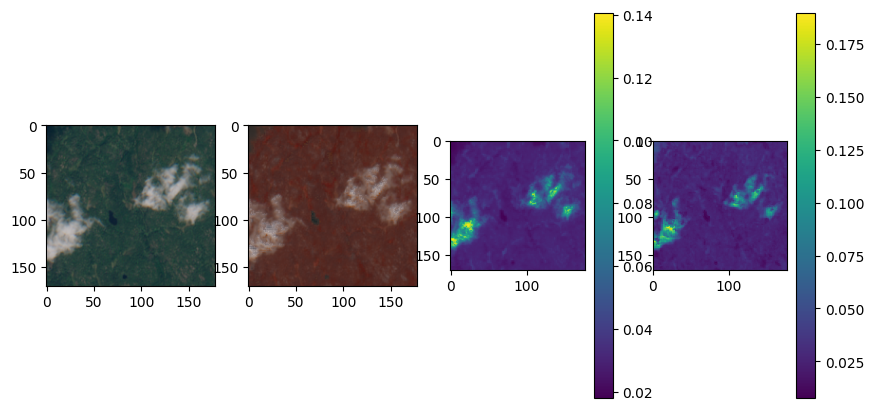

In [38]:
uncmeans = np.mean(im_unc,axis=2)
errs = np.abs(im_clear-im_pred)
errmeans = np.mean(errs,axis=2)

plt.rcParams['figure.figsize'] = [10, 5]
fig,axs =plt.subplots(ncols=4,nrows=1)
axs[0].imshow(ims_show[pair[1]])
axs[1].imshow(im_pred_show)
unc_img=axs[2].imshow(uncmeans)
fig.colorbar(unc_img,ax=axs[2])
err_img=axs[3].imshow(errmeans)
fig.colorbar(err_img,ax=axs[3])

In [39]:
#Import and plot means of clear surface types after RGB correction

#import data
df = synth_dataloader(path_name='SMHIdata2',drop_cols = False)
#Dumb down surfaces
df=hf.dumb_down_surface(df)

#Find means
clearcols = ['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06','Clear_B07','Clear_B08','Clear_B08A','Clear_B09','Clear_B10','Clear_B11','Clear_B12']
veg_mean = np.mean(df[df['Surface_Desc_Dumb']=='vegetation'][clearcols].to_numpy(),axis=0)
nonph_mean = np.mean(df[df['Surface_Desc_Dumb']=='nonphotosyntheticvegetation'][clearcols].to_numpy(),axis=0)
soil_mean = np.mean(df[df['Surface_Desc_Dumb']=='soil'][clearcols].to_numpy(),axis=0)
rock_mean = np.mean(df[df['Surface_Desc_Dumb']=='rock'][clearcols].to_numpy(),axis=0)
water_mean = np.mean(df[df['Surface_Desc_Dumb']=='water'][clearcols].to_numpy(),axis=0)

im_veg = np.tile(veg_mean,[im_pred.shape[0],im_pred.shape[1],1])
im_nonph = np.tile(nonph_mean,[im_pred.shape[0],im_pred.shape[1],1])
im_soil = np.tile(soil_mean,[im_pred.shape[0],im_pred.shape[1],1])
im_rock = np.tile(rock_mean,[im_pred.shape[0],im_pred.shape[1],1])
im_water = np.tile(water_mean,[im_pred.shape[0],im_pred.shape[1],1])

im_veg_show=TrueRGB(im_veg)
im_nonph_show=TrueRGB(im_nonph)
im_soil_show=TrueRGB(im_soil)
im_rock_show=TrueRGB(im_rock)
im_water_show=TrueRGB(im_water)




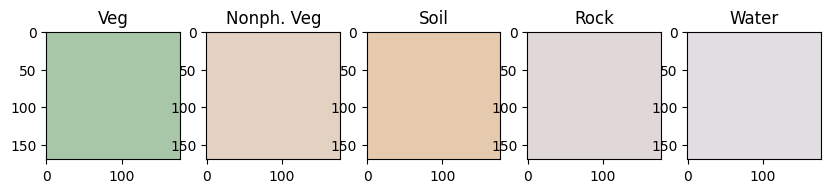

In [40]:
plt.rcParams['figure.figsize'] = [10, 5]
fig,axs =plt.subplots(ncols=5,nrows=1)
axs[0].imshow(im_veg_show)
axs[1].imshow(im_nonph_show)
axs[2].imshow(im_soil_show)
axs[3].imshow(im_rock_show)
axs[4].imshow(im_water_show)
axs[0].title.set_text('Veg')
axs[1].title.set_text('Nonph. Veg')
axs[2].title.set_text('Soil')
axs[3].title.set_text('Rock')
axs[4].title.set_text('Water')

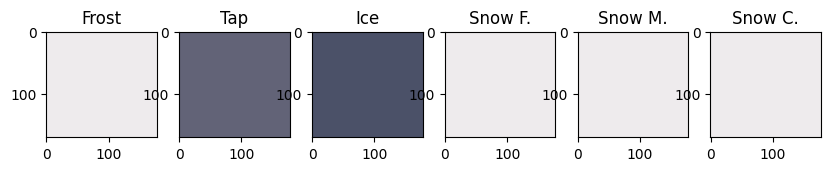

In [41]:
#import data
df_new = synth_dataloader(path_name='SMHIdata2_newsurf',drop_cols = False)
#All water surf
frost_mean = np.mean(df[df['Surface_Desc']=='water-frost-none'][clearcols].to_numpy(),axis=0)
tap_mean = np.mean(df[df['Surface_Desc']=='water-tapwater-none'][clearcols].to_numpy(),axis=0)
ice_mean = np.mean(df[df['Surface_Desc']=='water-ice-none'][clearcols].to_numpy(),axis=0)
snow_fine_mean = np.mean(df[df['Surface_Desc']=='water-snow-finegranular'][clearcols].to_numpy(),axis=0)
snow_med_mean = np.mean(df[df['Surface_Desc']=='water-snow-mediumgranular'][clearcols].to_numpy(),axis=0)
snow_coarse_mean = np.mean(df[df['Surface_Desc']=='water-snow-coarsegranular'][clearcols].to_numpy(),axis=0)

im_frost = np.tile(frost_mean,[im_pred.shape[0],im_pred.shape[1],1])
im_tap = np.tile(tap_mean,[im_pred.shape[0],im_pred.shape[1],1])
im_ice = np.tile(ice_mean,[im_pred.shape[0],im_pred.shape[1],1])
im_snowf = np.tile(snow_fine_mean,[im_pred.shape[0],im_pred.shape[1],1])
im_snowm = np.tile(snow_med_mean,[im_pred.shape[0],im_pred.shape[1],1])
im_snowc = np.tile(snow_coarse_mean,[im_pred.shape[0],im_pred.shape[1],1])

im_frost_show=TrueRGB(im_frost)
im_tap_show=TrueRGB(im_tap)
im_ice_show=TrueRGB(im_ice)
im_snowf_show=TrueRGB(im_snowf)
im_snowm_show=TrueRGB(im_snowm)
im_snowc_show=TrueRGB(im_snowc)

plt.rcParams['figure.figsize'] = [10, 5]
fig,axs =plt.subplots(ncols=6,nrows=1)
axs[0].imshow(im_frost_show)
axs[1].imshow(im_tap_show)
axs[2].imshow(im_ice_show)
axs[3].imshow(im_snowf_show)
axs[4].imshow(im_snowm_show)
axs[5].imshow(im_snowc_show)
axs[0].title.set_text('Frost')
axs[1].title.set_text('Tap')
axs[2].title.set_text('Ice')
axs[3].title.set_text('Snow F.')
axs[4].title.set_text('Snow M.')
axs[5].title.set_text('Snow C.')

